### Import related modules

In [8]:
import os
import numpy as np
import pandas as pd
import librosa
import whisper
from whisper import load_model, pad_or_trim, load_audio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

### Audio to text conversion
Call a library that converts speech to text.

In [10]:
def audio_to_text(audio_path, output_text_path):
    # Using Whisper base model and GPU acceleration
    model = whisper.load_model("base").to("cuda")
    audio = whisper.load_audio(audio_path)
    audio = whisper.pad_or_trim(audio)
    # Obtain the conversion result
    result = model.transcribe(audio)
    text = result['text']

    # Save transcribed text
    with open(output_text_path, "w") as f:
        f.write(text)
    return text

### Extract audio features

In [11]:
def extract_audio_features(file_path):
    # Loading audio files using the librosa library
    y, sr = librosa.load(file_path, sr=None)
    # Calculate Mel frequency cepstral coefficients
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    # Calculate the zero crossing rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    # Calculate root mean square
    rms = np.mean(librosa.feature.rms(y=y))
    # Splicing to obtain audio features
    return np.hstack([mfcc, zcr, rms])

### Extract text features

In [12]:
def extract_text_features(texts):
    vectorizer = TfidfVectorizer(max_features=17)
    return vectorizer.fit_transform(texts).toarray()

### Classification and voting mechanism (with added weights)

In [13]:
def train_and_evaluate(X_text, X_audio, y, model_save_path=None):
    # Split the data into training and test sets (80% training, 20% testing)
    X_text_train, X_text_test, X_audio_train, X_audio_test, y_train, y_test = train_test_split(
        X_text, X_audio, y, test_size=0.2, random_state=32
    )
    print(f"Number of text features: {X_text_train.shape[1]}")
    print(f"Audio feature count: {X_audio_train.shape[1]}")

    # Audio classifiers
    scaler = StandardScaler()
    # Standardizing audio features (scaling them to have mean=0 and std=1)
    X_audio_train = scaler.fit_transform(X_audio_train)
    X_audio_test = scaler.transform(X_audio_test)

    # Models for audio classification: kNN and Gaussian Naive Bayes
    models_audio = {
        "kNN": KNeighborsClassifier(n_neighbors=5),
        "GaussianNB": GaussianNB(),
    }

    predictions_audio = {}
    accuracy_audio = {}

    for name, model in models_audio.items():
        print(f"Training {name} (Audio features)...")
        model.fit(X_audio_train, y_train)
        pred = model.predict(X_audio_test)
        predictions_audio[name] = pred
        accuracy = accuracy_score(y_test, pred)
        accuracy_audio[name] = accuracy
        print(f"{name} (Audio features) Accuracy: {accuracy:.2f}")

    # Text classifiers using Logistic Regression and Random Forest
    models_text = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=15, random_state=32),
    }

    predictions_text = {}
    accuracy_text = {}

    for name, model in models_text.items():
        print(f"Training {name} (Text features)...")
        model.fit(X_text_train, y_train)
        pred = model.predict(X_text_test)
        predictions_text[name] = pred
        accuracy = accuracy_score(y_test, pred)
        accuracy_text[name] = accuracy
        print(f"{name} (Text features) Accuracy: {accuracy:.2f}")

    # Combine the accuracy of all models (text and audio)
    accuracies = {**accuracy_text, **accuracy_audio}

    # Voting mechanism for final prediction
    final_predictions = []
    for i in range(len(y_test)):
        votes = []
        for name, pred in {**predictions_text, **predictions_audio}.items():
            weight = accuracies.get(name, 0)
            votes.extend([pred[i]] * int(weight * 10))
        # Extend the votes list by the weight factor
        final_predictions.append(1 if votes.count(1) > votes.count(0) else 0)

    # Output the final accuracy after voting
    accuracy = accuracy_score(y_test, final_predictions)
    print(f"Final voting classification accuracy: {accuracy:.2f}")

    # Plot the confusion matrix to visualize the classification performance
    cm = confusion_matrix(y_test, final_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Deceptive", "True"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Save the model if specified
    if model_save_path:
        print(f"Saving model to {model_save_path}")
        joblib.dump({"text_models": models_text, "audio_models": models_audio, "scaler": scaler}, model_save_path)

### Use the trained model to predict new data

In [14]:
def predict_with_model(model_load_path, X_text, X_audio):
    print(f"Loading model from {model_load_path}")
    model_data = joblib.load(model_load_path)

    models_text = model_data["text_models"]
    models_audio = model_data["audio_models"]
    scaler = model_data["scaler"]

    # Standardize audio features
    X_audio = scaler.transform(X_audio)

    predictions_text = {}
    for name, model in models_text.items():
        pred = model.predict(X_text)
        predictions_text[name] = pred

    predictions_audio = {}
    for name, model in models_audio.items():
        pred = model.predict(X_audio)
        predictions_audio[name] = pred

    # Voting mechanism for final prediction
    final_predictions = []
    for i in range(len(X_text)):
        votes = []
        for name, pred in {**predictions_text, **predictions_audio}.items():
            votes.extend([pred[i]] * 10)  # Equal weight for all models here
        final_predictions.append(1 if votes.count(1) > votes.count(0) else 0)

    return final_predictions

### Main program

#### Train

In [15]:
# Run this block of code for training. You should put your dataset in "CBU0521DD_stories" file
print("Start loading data")
csv_file = "CBU0521DD_stories_attributes.csv"
folder_path = "CBU0521DD_stories"
df = pd.read_csv(csv_file)

df

Start loading data


,filename,Language,Story_type
0,00001.wav,Chinese,True Story
1,00002.wav,Chinese,True Story
2,00003.wav,Chinese,True Story
3,00004.wav,Chinese,True Story
4,00005.wav,Chinese,True Story
...,...,...,...
95,00096.wav,English,True Story
96,00097.wav,Chinese,Deceptive Story
97,00098.wav,Chinese,True Story
98,00099.wav,Chinese,Deceptive Story


In [16]:
audio_files = df["filename"].values
labels = df["Story_type"].map({"True Story": 1, "Deceptive Story": 0}).values

texts = []
print("Start audio to text conversion")
for i, file in enumerate(audio_files):
    file_path = os.path.join(folder_path, file)
    output_text_path = os.path.join(folder_path, f"{file[:-4]}.txt")

    # If the audio has been conversed to text and saved, it doesn't need to converse again
    if os.path.exists(output_text_path):
        with open(output_text_path, "r") as f:
            text = f.read()
    else:
        text = audio_to_text(file_path, output_text_path)
    texts.append(text)
    
texts

Start audio to text conversion


['2021年的冬天,我回了一趟老家探望外婆,那年她身體不好,住在離村子不遠的小鎮醫院裡。冬天的風特別刺骨,我淚著一大兒她喜歡吃的水果,走進了醫院。外婆見到我時,臉上露出了久違的笑容。她說,你怎麼知道我最想吃的就是橙子。我們在病房裡聊了很多,我問她',
 '2022年属價,我終於實現了去雲南旅行的夢想雲南的美景和獨特文化一直是我向往的而這次旅行讓我深深感受到它的魅力最讓我難忘的是在R海邊騎行的一天那種自由和寧靜的感覺至今難忘清晨,我從大力古城租了一輛自行車沿著R海的湖邊小道騎行R海的水面在清晨十分如鏡子般平靜這次旅行,我從大力古城租了一輛自行車沿著R海的湖邊小道騎行R海的水面在清晨十分如鏡子般平靜的感覺沿著R海的水面在清晨十分如鏡子般平靜的感覺',
 '这是我的故事。我的旅程,从驻名的故宫开始,它是世界上最大,保存最完整的皇宫建筑群。到我踏入那巨大的红色公文时,仿佛穿越到了历史中。今美的雕刻,经辟灰皇的污顶和广阔的停月,展现了明清皇朝的灰红气势。在游览太和电河预花圆时,我对这里建筑工艺,很丰富历史。',
 '在2020年,我報名參加了學校組織的美國嚴選活動我跟我的另外兩個同學以及許多老師同學們一起參加了這次美國旅行在1月15號文迪達的美國紐約之後的旅行都是乘坐大巴進行的我跟同學一起吃了一頓非常豐盛的早餐那是一家中式餐廳早餐有熟悉的包子、腳子、粥',
 '今天我想和大家分享我去年的闪西之旅,当我踏上这片古老的土地,心中充满了期待与尽为。我在闪西之旅的第一站是西安,这座千年古度仿佛叔叔这历史的苍苍。外部在古城墙上,我仿佛等听到历史的回应,每一块专时都成在这后重的历史。走进冰馬泳泊不管,那一列列徐徐如生的陶勇,让我感受。',
 '我曾经在一年内数次去过南京真的是一个很美丽的城市我最好的哥们在那边上学我们一起在小门外小世界大快多一万不一和路之间起过无数野营的城墙下我最好的哥们在那边上学小世界大快多一小世界大快多一小世界大快多一小世界大快多一小世界大快多一小世界大快多一小世界大快多一小世界大快多一小世界大快多一小世界大快多一小世界大快多一',
 '去年秋天在国星加级期间我去了航州开房了一个多年位建案的朋友这次旅程对我来说非常特别因为航州是我一直想去还没有去的地方而这位航州而这位朋友是我的高中同学我们自动上大学我就各自忙碌在没有见面那天我一早坐上去航州的高铁车中卖景色从房号的城

In [17]:
print("Extract Text Features")
X_text = extract_text_features(texts)

print("Extract audio features")
X_audio = np.array([extract_audio_features(os.path.join(folder_path, file)) for file in audio_files])

X_text,X_audio

Extract Text Features
Extract audio features


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[-6.05132446e+02,  1.14067970e+02,  3.42377472e+01, ...,
          2.37275743e+00,  5.76193989e-02,  4.47421800e-03],
        [-3.16850677e+02,  1.36820221e+02, -7.29796553e+00, ...,
         -4.75399303e+00,  5.73729022e-02,  5.08690625e-02],
        [-3.26685089e+02,  1.59831558e+02, -2.66239243e+01, ...,
          1.29651299e+01,  5.09669179e-02,  7.53609985e-02],
        ...,
        [-5.01262573e+02,  1.43559738e+02,  3.80389862e+01, ...,
          3.04572868e+00,  2.84382179e-02,  1.83839984e-02],
        [-5.01765289e+02,  1.44467087e+02,  4.11431961e+01, ...,
          5.16555682e-02,  2.68982553e-02,  1.77746676e-02],
        [-3.40805969e+02,  1.44819595e+02,  2.28754082e+01, ...,
         -1.34323521e+01,  4.21720951e-02, 

Training and evaluating models
Number of text features: 17
Audio feature count: 15
Training kNN (Audio features)...
kNN (Audio features) Accuracy: 0.70
Training GaussianNB (Audio features)...
GaussianNB (Audio features) Accuracy: 0.80
Training LogisticRegression (Text features)...
LogisticRegression (Text features) Accuracy: 0.55
Training RandomForest (Text features)...
RandomForest (Text features) Accuracy: 0.40
Final voting classification accuracy: 0.85


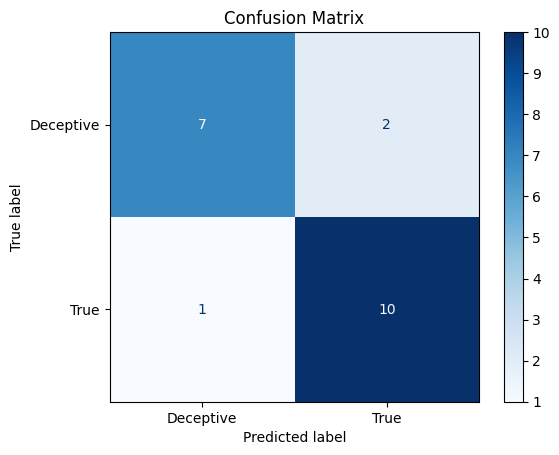

Saving model to trained_model.pkl


In [18]:
print("Training and evaluating models")
model_save_path = "trained_model.pkl"
train_and_evaluate(X_text, X_audio, labels, model_save_path)

#### Predict

In [19]:
# Run this block of code for predicting. You should put your prediction dataset in "predict" file, and make sure you have run the training block.
print("Start loading model")
model_load_path = "trained_model.pkl"
if os.path.exists(model_load_path) is False:
    print("Model does not exist")
    exit(0)
print("End loading model")

Start loading model
End loading model


In [20]:
# Use 00001.wav and 00002.wav.
print("Start loading data for prediction")
test_folder_path = "predict"
audio_files = [f for f in os.listdir(test_folder_path) if f.endswith(".wav")]
audio_files

Start loading data for prediction


['00001.wav', '00002.wav']

In [21]:
print("Start audio to text conversion")
texts = []
file_name = []
for file in audio_files:
    file_path = os.path.join(test_folder_path, file)
    file_name.append(file)
    output_text_path = os.path.join(test_folder_path, f"{file[:-4]}.txt")

    if os.path.exists(output_text_path):
        with open(output_text_path, "r") as f:
            text = f.read()
    else:
        text = audio_to_text(file_path, output_text_path)
    texts.append(text)
    
texts

Start audio to text conversion


['2021年的冬天,我回了一趟老家探望外婆,那年她身體不好,住在離村子不遠的小鎮醫院裡。冬天的風特別刺骨,我淚著一大兒她喜歡吃的水果,走進了醫院。外婆見到我時,臉上露出了久違的笑容。她說,你怎麼知道我最想吃的就是橙子。我們在病房裡聊了很多,我問她',
 '2022年属價,我終於實現了去雲南旅行的夢想雲南的美景和獨特文化一直是我向往的而這次旅行讓我深深感受到它的魅力最讓我難忘的是在R海邊騎行的一天那種自由和寧靜的感覺至今難忘清晨,我從大力古城租了一輛自行車沿著R海的湖邊小道騎行R海的水面在清晨十分如鏡子般平靜這次旅行,我從大力古城租了一輛自行車沿著R海的湖邊小道騎行R海的水面在清晨十分如鏡子般平靜的感覺沿著R海的水面在清晨十分如鏡子般平靜的感覺']

In [22]:
print("Extract Text Features")
X_text = extract_text_features(texts)

print("Extract audio features")
X_audio = np.array([extract_audio_features(os.path.join(test_folder_path, file)) for file in audio_files])

X_text,X_audio

Extract Text Features
Extract audio features


(array([[0.2773501, 0.       , 0.2773501, 0.2773501, 0.2773501, 0.2773501,
         0.2773501, 0.2773501, 0.2773501, 0.2773501, 0.       , 0.       ,
         0.2773501, 0.       , 0.2773501, 0.2773501, 0.2773501],
        [0.       , 0.5      , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.5      , 0.5      ,
         0.       , 0.5      , 0.       , 0.       , 0.       ]]),
 array([[-6.05132446e+02,  1.14067970e+02,  3.42377472e+01,
          2.65087910e+01,  1.41764011e+01, -8.32415760e-01,
         -2.44422957e-01,  1.98408210e+00,  3.51478124e+00,
          1.42658520e+00,  8.36694300e-01,  5.75649929e+00,
          2.37275743e+00,  5.76193989e-02,  4.47421800e-03],
        [-3.16850677e+02,  1.36820221e+02, -7.29796553e+00,
          3.91325798e+01,  1.15830936e+01, -1.96725762e+00,
         -9.38264561e+00,  1.46135693e+01, -4.95661879e+00,
         -1.58024426e+01,  1.32620287e+00, -1.10350657e+01,
         -4.75399303e+00,  

In [23]:
predictions = predict_with_model(model_load_path, X_text, X_audio)
with open("result.txt", "w") as f:
    for i in range(len(predictions)):
        print(f"Data: {file_name[i]}, Prediction: {predictions[i]}")
        f.write(f"Data: {file_name[i]}, Prediction: {predictions[i]}\n")
print("The result has been saved in result.txt")

Loading model from trained_model.pkl
Data: 00001.wav, Prediction: 1
Data: 00002.wav, Prediction: 0
The result has been saved in result.txt
